# INTRODUCTION
Megaline is a mobile carrier. They recently found out that many of their subscribers user the legacy plan. We are going to test and develop a model that will analyze subscriber's behavior and recommend one of Megaline's newer plans: Smart or Ultra. 

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

In [2]:
users_info = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
users_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
users_info.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
users_info.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [6]:
users_info.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [7]:
users_info.duplicated().sum()

0

SUMMARY ON INFO ABOVE
- There are 3213 users and two different datatypes- float and integer.
- The first and last 5 rows have been listed.
- There are no missing values in the dataset.
- There are no duplicated values in the dataset.

## 
Split the source data into a training set, a validation set, and a test set

In [8]:
# Separate features (X) and target variable (y)
X = users_info.drop(columns=['is_ultra']) # Features: calls, minutes, messages, mb_used  
y = users_info['is_ultra']  # Target variable: is_ultra (0 or 1)

# Split the data into training and temporary (validation + test) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of each set to verify the split
print("Training set:", X_train_temp.shape, y_train_temp.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (2249, 4) (2249,)
Validation set: (482, 4) (482,)
Test set: (483, 4) (483,)


- Splitting into training and temporary sets: I split the entire dataset into 70% training and 30% temporary sets using 'train_test_split()' with 'test_size=0.3'.
- Splitting the temporary set into validation and test sets: I further split the temporary set into equal halves (15% each of the original dataset size) for validation and test sets using 'train_test_split()' with 'test_size=0.5'.
- Setting 'random_state' ensures reproducibility, so you get the same splits each time you run the code, which is crucial for consistency in model evaluation.

## 
- Investigate the quality of different models by changing hyperparameters. Briefly describe the findings of the study.
- Check the quality of the model using the test set.

### Example of Logistic Regression

In [9]:
# Define the function for the model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return accuracy, precision, recall, f1

In [10]:
# Initialize logistic regression model
logreg = LogisticRegression(random_state=42)

# Evaluate on validation set
accuracy, precision, recall, f1 = evaluate_model(logreg, X_train_temp, y_train_temp, X_val, y_val)

# Print evaluation metrics
print("Default Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Default Logistic Regression Performance:
Accuracy: 0.7635
Precision: 0.8000
Recall: 0.2553
F1-score: 0.3871


In [11]:
# Define hyperparameters to search over
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization parameter
    'penalty': ['l1', 'l2'],              # regularization type
    'solver': ['liblinear', 'lbfgs'],     # algorithm to use in optimization problem
    'class_weight': [None, 'balanced']    # weights associated with classes
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

# Perform grid search to find best hyperparameters
grid_search.fit(X_train_temp, y_train_temp)

# Get the best model
best_logreg = grid_search.best_estimator_

# Print best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate model with best hyperparameters on validation set
best_model = grid_search.best_estimator_
accuracy, precision, recall, f1 = evaluate_model(best_model, X_train_temp, y_train_temp, X_val, y_val)

# Print evaluation metrics
print("\nBest Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/envs/python3/lib/pytho

Best Hyperparameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

Best Logistic Regression Performance:
Accuracy: 0.7033
Precision: 0.3333
Recall: 0.0142
F1-score: 0.0272


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70164514        nan 0.71231774 0.73011235 0.34458599        nan
 0.43351547 0.49305122 0.70564712        nan 0.71098144 0.73100124
 0.38416036        nan 0.54378718 0.45349864 0.7443316         nan
 0.71409156 0.72522346 0.63450631        nan 0.61804306 0.49616531
 0.74611235        nan 0.72344172 0.72522346 0.64161742        nan
 0.62559861 0.64161742 0.74611235        nan 0.72966394 0.72522346
 0.64117298        nan 0.63895075 0.64161742 0.74611235        nan
 0.72966394 0.72522346 0.64161742        nan 0.63406187 0.64161742]
  warnings.warn(


### Example of linear regression

In [12]:
# Define the function for the model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, r2

In [13]:
# Initialize linear regression model
linreg = LinearRegression()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluate on validation set
mse, r2 = evaluate_model(linreg, X_train, y_train, X_val, y_val)

# Print evaluation metrics
print("Default Linear Regression Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Default Linear Regression Performance:
Mean Squared Error (MSE): 0.2019
R-squared (R2): 0.0660


In [14]:
# Define hyperparameters to search over
param_grid = {
    'normalize': [True, False],  # normalize the data (only relevant for certain algorithms)
    'fit_intercept': [True, False]  # whether to calculate the intercept for this model
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LinearRegression(),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # using negative MSE to maximize performance
                           verbose=1,
                           n_jobs=-1)

# Perform grid search to find best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best linear regression model
best_linreg = grid_search.best_estimator_

# Print best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate model with best hyperparameters on validation set
best_model = grid_search.best_estimator_
mse, r2 = evaluate_model(best_model, X_train, y_train, X_val, y_val)

# Print evaluation metrics
print("\nBest Linear Regression Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'fit_intercept': True, 'normalize': False}

Best Linear Regression Performance:
Mean Squared Error (MSE): 0.2019
R-squared (R2): 0.0660


### Example of decision tree

In [15]:
# Define the function for the model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return accuracy, precision, recall, f1, model

In [16]:
# Initialize decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluate on validation set
accuracy, precision, recall, f1, dt_clf = evaluate_model(dt_clf, X_train, y_train, X_val, y_val)

# Print evaluation metrics
print("Default Decision Tree Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Default Decision Tree Performance:
Accuracy: 0.7212
Precision: 0.5596
Recall: 0.5541
F1-score: 0.5568


In [17]:
# Define hyperparameters to search over
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

# Perform grid search to find best hyperparameters
grid_search.fit(X_train, y_train)

# Print best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate model with best hyperparameters on validation set
best_dt_clf = grid_search.best_estimator_
accuracy, precision, recall, f1, best_dt_clf = evaluate_model(best_dt_clf, X_train, y_train, X_val, y_val)

# Print evaluation metrics
print("\nBest Decision Tree Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

Best Decision Tree Performance:
Accuracy: 0.7845
Precision: 0.7904
Recall: 0.4328
F1-score: 0.5593


## 
Sanity check the model. This data is more complex than what you’re used to working with, so it's not an easy task. We'll take a closer look at it later.

Feature: calls, Coefficient: 0.0000
Feature: minutes, Coefficient: -0.0002
Feature: messages, Coefficient: 0.0037
Feature: mb_used, Coefficient: -0.0000


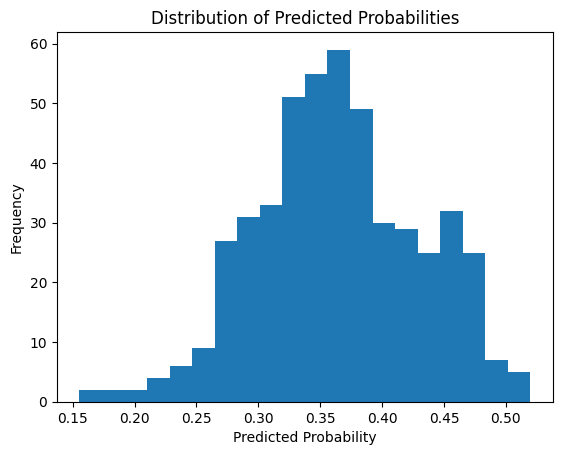

In [18]:
# Sanity check for Logistic Regression
# Assuming best_logreg is your trained logistic regression model
coefficients = best_logreg.coef_[0]
feature_names = X.columns

for feat, coef in zip(feature_names, coefficients):
    print(f"Feature: {feat}, Coefficient: {coef:.4f}")
    
# Predict probabilities on the test set
y_pred_prob = best_logreg.predict_proba(X_test)[:, 1]

# Check the distribution of predicted probabilities
import matplotlib.pyplot as plt

plt.hist(y_pred_prob, bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

Feature: calls, Coefficient: -0.0005
Feature: minutes, Coefficient: 0.0004
Feature: messages, Coefficient: 0.0021
Feature: mb_used, Coefficient: 0.0000
Intercept: -0.0425


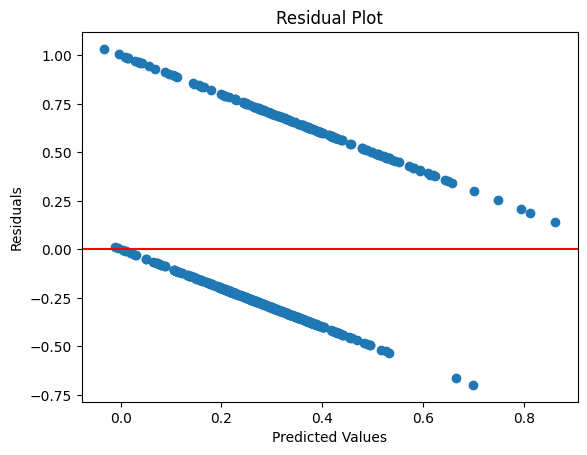

In [19]:
# Sanity check for Linear Regression
# Assuming best_linreg is your trained linear regression model
coefficients = best_linreg.coef_
intercept = best_linreg.intercept_

for feat, coef in zip(feature_names, coefficients):
    print(f"Feature: {feat}, Coefficient: {coef:.4f}")

print(f"Intercept: {intercept:.4f}")

# Predict on test set
y_pred = best_linreg.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [20]:
# Sanity check for Decision Tree
# Assuming best_dt_clf is your trained decision tree classifier
feature_importances = best_dt_clf.feature_importances_

for feat, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feat}, Importance: {importance:.4f}")

print(f"Depth of Decision Tree: {best_dt_clf.get_depth()}")
print(f"Number of Nodes in Decision Tree: {best_dt_clf.tree_.node_count}")

Feature: calls, Importance: 0.1146
Feature: minutes, Importance: 0.3589
Feature: messages, Importance: 0.2093
Feature: mb_used, Importance: 0.3172
Depth of Decision Tree: 10
Number of Nodes in Decision Tree: 189


# OVERALL CONCLUSION

Megaline is a mobile carrier with different plans for users. Above there is testing for three different machine learning algorithms: Logistic Regression, Linear Regression, and Decision Tree. The accuracy score for all 3 tests are within .05 of the threshold. 